# Pedro - Short Queeze Predictor
---

### 1. Libraries Import

In [367]:
import os
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import seaborn as sns
import xgboost as xgb
from joblib import dump
import tensorflow as tf
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder

### 2. Data Import

In [339]:
# Read the ShortSqueezeData.csv file into a Pandas DataFrame
merged_df = pd.read_csv(
    Path("Resources/ShortSqueezeData.csv"),
    parse_dates=True,
    infer_datetime_format=True
)

In [340]:
# Review the DataFrame
merged_df

,Date,Symbol,Short % of Float,Total Amount,Market Cap,% Insider Ownership,Relation,Sector,% from 50 day MA,Return (5 Days),Return (7 Days),Return (15 Days),Return (30 Days),Short Squeeze
0,2022-08-19,ABCL,10.26,2292460.0,3.210520e+09,28.82,Large Shareholder,Healthcare,8.61,6.47,-7.08,-2.10,-13.55,0
1,2021-07-19,AFIB,12.34,9999990.0,4.334698e+08,2.26,"Large Shareholder, Director",Healthcare,7.70,24.72,11.05,15.53,-0.30,1
2,2022-05-24,AHCO,12.52,1727230.0,2.269454e+09,27.42,Director,Healthcare,11.01,3.69,4.78,-0.58,11.01,0
3,2022-06-13,AHCO,10.25,1722010.0,2.490455e+09,27.42,Director,Healthcare,19.33,0.35,4.25,7.33,22.40,1
4,2022-06-14,AHCO,10.25,1705592.7,2.490455e+09,27.42,Director,Healthcare,19.33,1.86,6.49,8.46,23.71,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,2021-11-22,VCTR,10.62,1017828.0,5.638365e+08,3.04,Officer,Financial Services,-3.65,2.66,4.41,-1.02,5.67,0
241,2021-11-23,VCTR,10.62,500500.9,5.638365e+08,3.04,Director,Financial Services,-3.65,-0.37,3.04,-2.22,-0.06,0
242,2022-03-03,W,21.38,1222400.0,9.837764e+09,6.07,Director,Consumer Cyclical,-16.46,2.12,-7.76,-2.43,-5.71,0
243,2022-05-19,W,29.20,1745100.0,3.533396e+09,6.07,Director,Consumer Cyclical,-51.66,1.17,18.74,8.61,-8.85,1


In [341]:
# Short Squeeze vs. Non Short Squeeze Counts in DataFrame
short_squeeze_count = merged_df.loc[merged_df['Short Squeeze'] == 1, 'Short Squeeze'].count()
no_short_squeeze_count = merged_df.loc[merged_df['Short Squeeze'] == 0, 'Short Squeeze'].count()

print("Short Squeeze:", short_squeeze_count)
print("Non Short Squeeze:", no_short_squeeze_count)

Short Squeeze: 99
Non Short Squeeze: 146


### 3. Data Visualization

<Figure size 1000x600 with 0 Axes>

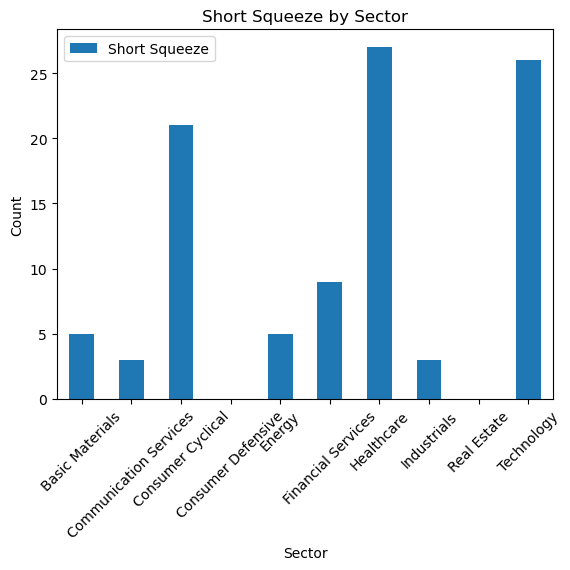

In [342]:
# Visualization by Sector
plt.figure(figsize=(10, 6))
grouped_df = merged_df.groupby('Sector')['Short Squeeze'].sum().reset_index()
grouped_df.plot(x='Sector', y='Short Squeeze', kind='bar')
plt.title('Short Squeeze by Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Figure size 800x600 with 0 Axes>

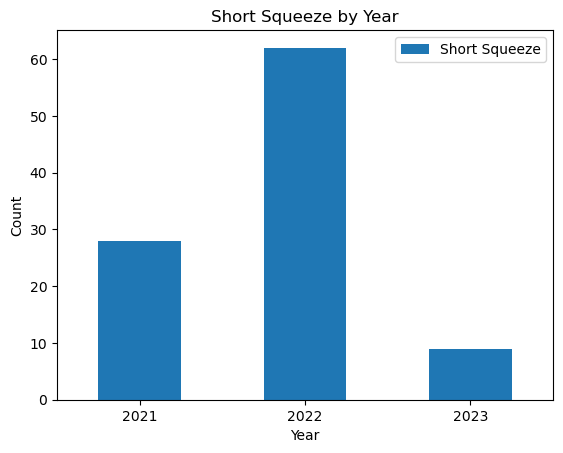

In [343]:
# Visualization by Year
merged_df['Year'] = pd.to_datetime(merged_df['Date']).dt.year
plt.figure(figsize=(8, 6))
grouped_df = merged_df.groupby('Year')['Short Squeeze'].sum().reset_index()
grouped_df.plot(x='Year', y='Short Squeeze', kind='bar')
plt.title('Short Squeeze by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### 4. One Hot Encoding

In [344]:
def one_hot_encode(df):
    encoder = OneHotEncoder(sparse=False)
    categorical_variables = ['Sector']
    encoded_data = encoder.fit_transform(df[categorical_variables])
    encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_variables))
    encoded_df.index = df.index 
    numerical_df = df.drop(columns=categorical_variables, axis=1)
    return pd.concat([numerical_df, encoded_df], axis=1)

In [345]:
merged_df = one_hot_encode(merged_df)

### 5. Train-Test Split

In [346]:
X = merged_df.drop(columns=['Short Squeeze', 'Symbol', 'Date', 'Return (5 Days)', 'Return (7 Days)', 'Return (15 Days)', 'Return (30 Days)', 'Relation', '% Insider Ownership', 'Total Amount'])
y = merged_df['Short Squeeze']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Data Normalization

In [347]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 7. Class Balancing

#### Synthetic Minority Over-sampling Technique (SMOTE)

In [348]:
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Print the class counts
print(pd.Series(y_train_resampled).value_counts())

0    111
1    111
Name: Short Squeeze, dtype: int64


### 8. Model Training

In [349]:
# Function for training and evaluating a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    if isinstance(model, Sequential):
        y_train = np.array(y_train).reshape(-1, 1)
        y_test = np.array(y_test).reshape(-1, 1)
        
        model.fit(X_train, y_train, epochs=50, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        model_name = "\033[1mNeural Network\033[0m"
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_name = "\033[1m" + type(model).__name__ + "\033[0m"
        
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    plot_confusion_matrix(y_test, y_pred, model_name)

In [350]:
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Confusion Matrix for model: {}'.format(model_name)
    plt.title(title)
    plt.show()

In [351]:
# Neural Network model
model_nn = Sequential()
model_nn.add(Dense(32, input_dim=X_train_resampled.shape[1], activation='relu'))
model_nn.add(Dense(16, activation='relu'))
model_nn.add(Dense(1, activation='sigmoid'))  
model_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

models = {
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42),
    'Support Vector Classifier': SVC(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=0),
    'XGBoost Classifier': xgb.XGBClassifier(),
    'Neural Network': model_nn
}

### 9. Model Evaluation Visualizations

Classification Report for GradientBoostingClassifier:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74        35
           1       0.45      0.71      0.56        14

    accuracy                           0.67        49
   macro avg       0.65      0.69      0.65        49
weighted avg       0.74      0.67      0.69        49

Confusion Matrix:


/Users/regulolanz/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


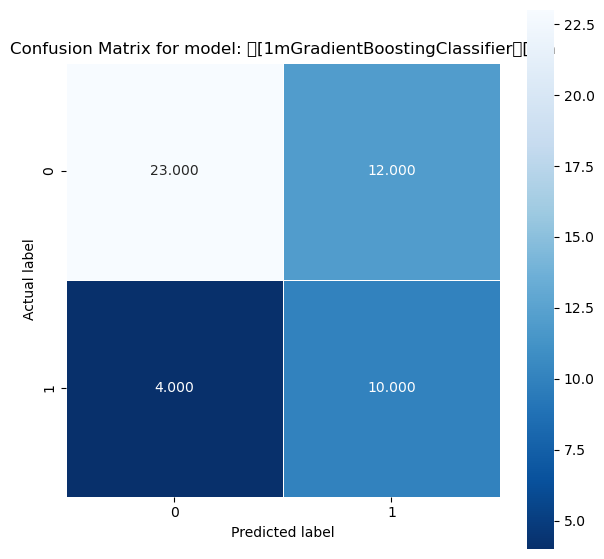

--------------------------------------------------------
Classification Report for SVC:
              precision    recall  f1-score   support

           0       0.77      0.49      0.60        35
           1       0.33      0.64      0.44        14

    accuracy                           0.53        49
   macro avg       0.55      0.56      0.52        49
weighted avg       0.65      0.53      0.55        49

Confusion Matrix:


/Users/regulolanz/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


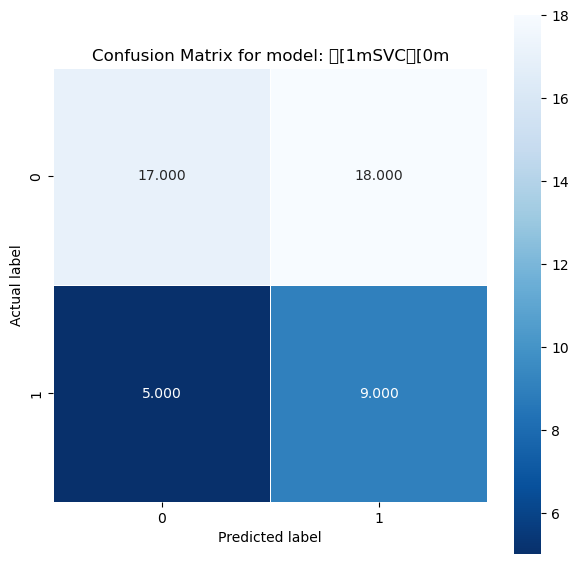

--------------------------------------------------------
Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.81      0.60      0.69        35
           1       0.39      0.64      0.49        14

    accuracy                           0.61        49
   macro avg       0.60      0.62      0.59        49
weighted avg       0.69      0.61      0.63        49

Confusion Matrix:


/Users/regulolanz/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


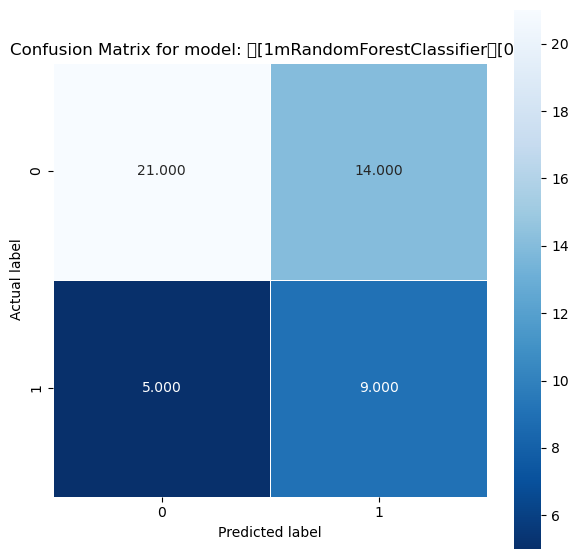

--------------------------------------------------------
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.83      0.57      0.68        35
           1       0.40      0.71      0.51        14

    accuracy                           0.61        49
   macro avg       0.62      0.64      0.60        49
weighted avg       0.71      0.61      0.63        49

Confusion Matrix:


/Users/regulolanz/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


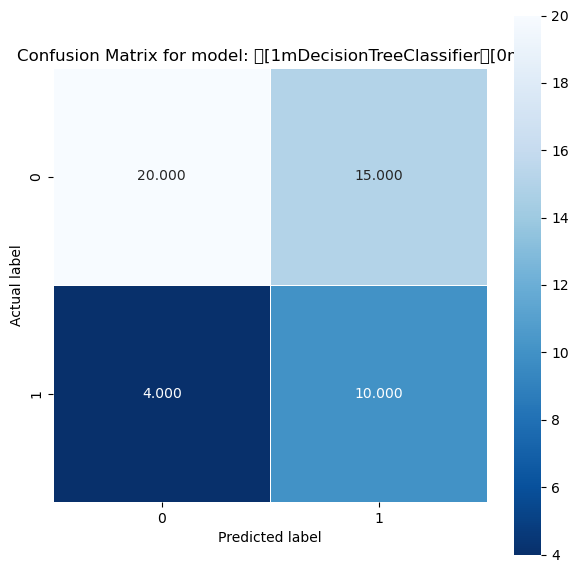

--------------------------------------------------------
Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        35
           1       0.47      0.64      0.55        14

    accuracy                           0.69        49
   macro avg       0.65      0.68      0.66        49
weighted avg       0.73      0.69      0.71        49

Confusion Matrix:


/Users/regulolanz/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


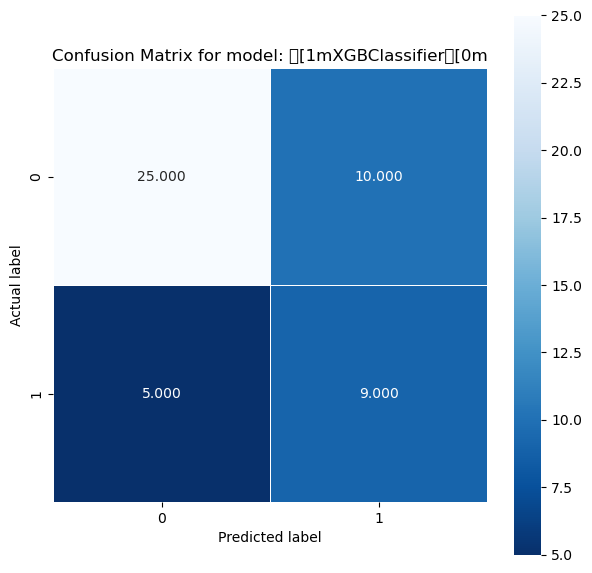

--------------------------------------------------------
2/2 [==============================] - 0s 2ms/step
Classification Report for Neural Network:
              precision    recall  f1-score   support

           0       0.83      0.57      0.68        35
           1       0.40      0.71      0.51        14

    accuracy                           0.61        49
   macro avg       0.62      0.64      0.60        49
weighted avg       0.71      0.61      0.63        49

Confusion Matrix:


/Users/regulolanz/anaconda3/envs/dev/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


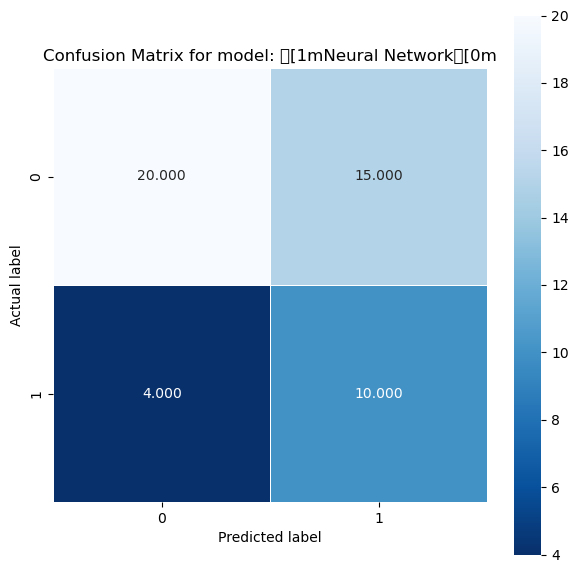

--------------------------------------------------------


In [356]:
for model_name, model in models.items():
    train_and_evaluate_model(model, X_train_resampled, y_train_resampled, X_test_scaled, y_test)
    print("--------------------------------------------------------")

In [363]:
def plot_comparison(models):
    metrics = ['accuracy', 'precision', 'recall', 'f1-score']
    scores = []
    labels = []
    
    for model_name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        if isinstance(model, xgb.XGBClassifier):
            y_pred = (y_pred > 0.5).astype("int32")
        else:
            y_pred = y_pred.round().astype("int32")
        report = classification_report(y_test, y_pred, output_dict=True)
        scores.append([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']])
        labels.append(model_name)
    
    scores_df = pd.DataFrame(scores, columns=metrics, index=labels)
    scores_df.plot(kind='bar', figsize=(10, 6))
    plt.title('Model Performance Comparison')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.show()

2/2 [==============================] - 0s 2ms/step


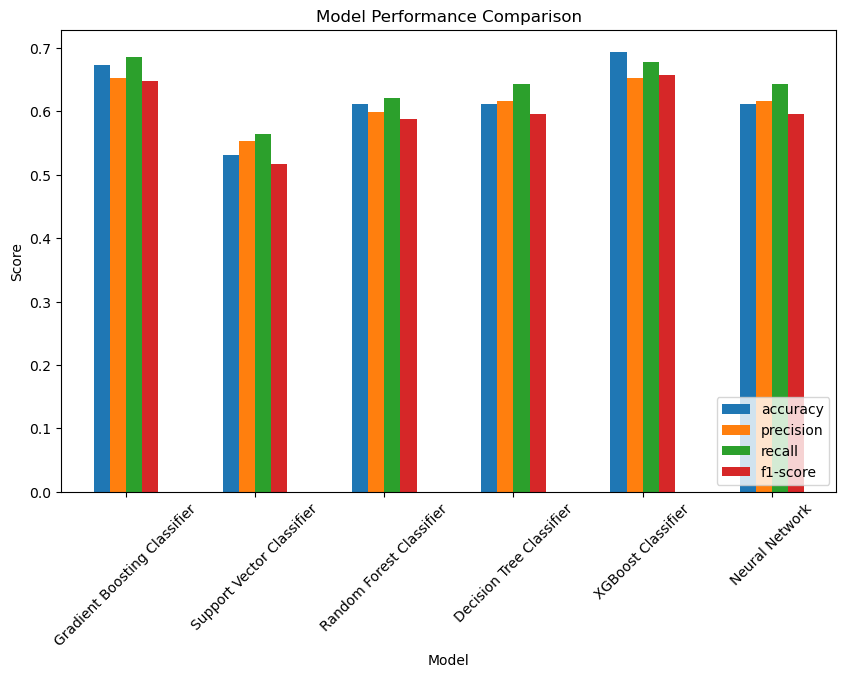

In [364]:
plot_comparison(models)

### 10. Saving the Trained Model

In [368]:
def save_models(models_dict, folder_path='Models'):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for name, model in models_dict.items():
        # Save each model to a separate file in the 'Models' folder
        joblib.dump(model, os.path.join(folder_path, f"{name.replace(' ', '_')}.joblib"))
        
print("Function 'save_models' defined.")

Function 'save_models' defined.


In [369]:
save_models(models)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-07-13 12:10:00         1835
metadata.json                                  2023-07-13 12:10:00           64
variables.h5                                   2023-07-13 12:10:00        36264
